# Classifying Planets

## Introduction

In this classification problem, we embark on a journey where we are presented with a synthetic dataset of planets and moons of our solar system. Our mission is clear: **classify from an image the planet or moon**.

In [1]:
import os
import random
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

2025-09-16 00:27:11.541267: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-16 00:27:11.601309: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-16 00:27:11.631545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757975231.660985    7287 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757975231.670897    7287 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757975231.709177    7287 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Set the random seed for reproducibility
seed = 77

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(seed)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

## Load the data

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "data/raw",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128)
)

Found 1605 files belonging to 11 classes.


E0000 00:00:1757975255.887164    7287 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1757975255.888777    7287 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Exploring the data

In [4]:
print('Data shape:', dataset.element_spec[0].shape)
print('Data type:', dataset.element_spec[0].dtype)
print('Label shape:', dataset.element_spec[1].shape)
print('Label type:', dataset.element_spec[1].dtype)

labels = dataset.class_names

# Print the labels
print("Labels:")
for i, label in enumerate(labels):
    print(f"{i:4}: {label}")


Data shape: (None, 128, 128, 3)
Data type: <dtype: 'float32'>
Label shape: (None,)
Label type: <dtype: 'int32'>
Labels:
   0: Earth
   1: Jupiter
   2: MakeMake
   3: Mars
   4: Mercury
   5: Moon
   6: Neptune
   7: Pluto
   8: Saturn
   9: Uranus
  10: Venus


2025-09-16 00:27:43.179705: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


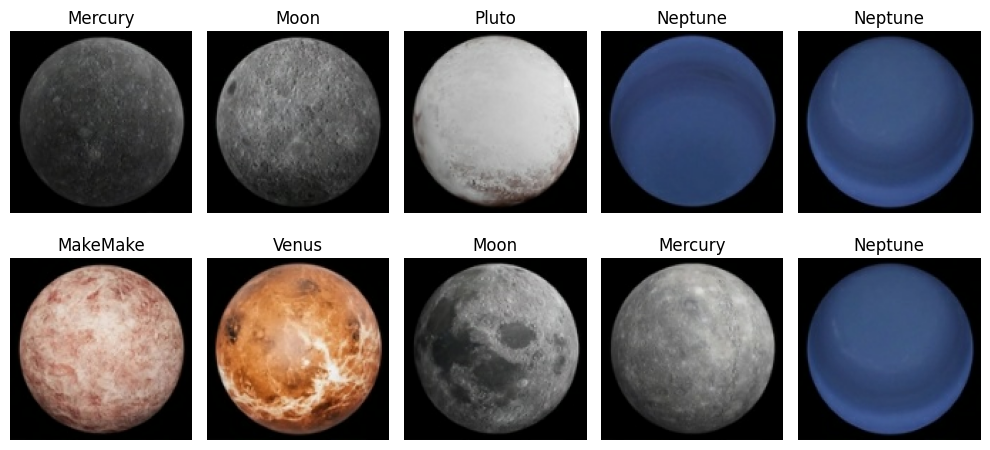

In [5]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

## Preparing the data

The following steps are performed to prepare the data:

- Shuffling the data
- Splitting the data into training and validation sets
- Normalizing the data

In [6]:
ds_train, ds_test = tf.keras.utils.image_dataset_from_directory(
    "data/raw",
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="both",
)

Found 1605 files belonging to 11 classes.
Using 1284 files for training.
Using 321 files for validation.


2025-09-16 00:27:52.928548: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


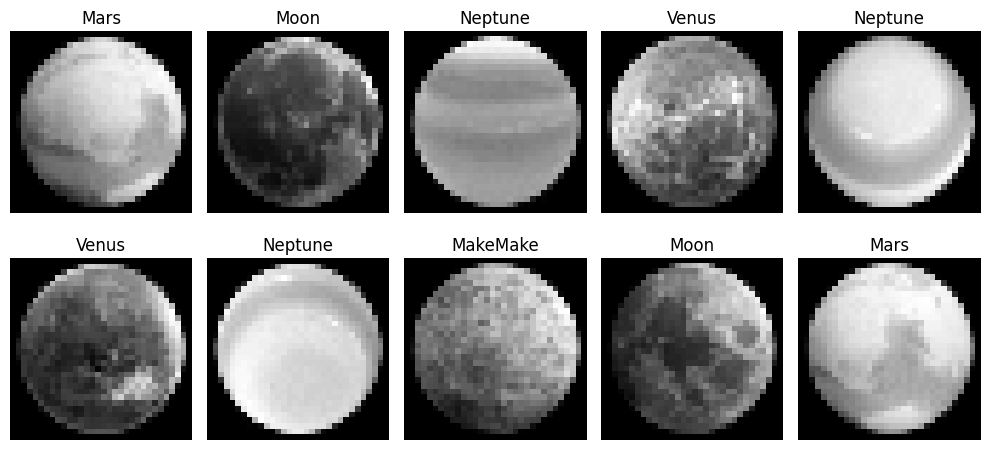

In [7]:
# Plot 10 sample images
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_train.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.title(labels[label_idxs[i].numpy()])
        plt.axis("off")

In [8]:
# Normalize the data
normalization_layer = tf.keras.layers.Rescaling(
    1.0 / 255
)
ds_train = ds_train.map(lambda x, y: (normalization_layer(x), y))
ds_test = ds_test.map(lambda x, y: (normalization_layer(x), y))


## Training the model

In [9]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(32, 32, 1)
        ),
        tf.keras.layers.MaxPooling2D((3, 3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(11),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

/home/cris/mlops/a-guide-to-mlops-jupyter-notebook/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,899 (804.29 KB)

 Trainable params: 205,899 (804.29 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s -1078us/step - loss: 2.3578 - sparse_categorical_accuracy: 0.0864 - val_loss: 2.3123 - val_sparse_categorical_accuracy: 0.0685
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.2780 - sparse_categorical_accuracy: 0.1031 - val_loss: 2.2416 - val_sparse_categorical_accuracy: 0.1526
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.1935 - sparse_categorical_accuracy: 0.2071 - val_loss: 2.1534 - val_sparse_categorical_accuracy: 0.2368
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.1051 - sparse_categorical_accuracy: 0.2625 - val_loss: 2.0386 - val_sparse_categorical_accuracy: 0.3801
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.9919 - sparse_categorical_accuracy: 0.5005 - val_loss: 1.9090 - val_sparse_categorical_accuracy: 0.3551


## Model Evaluation

Evaluate the model on the validation set.

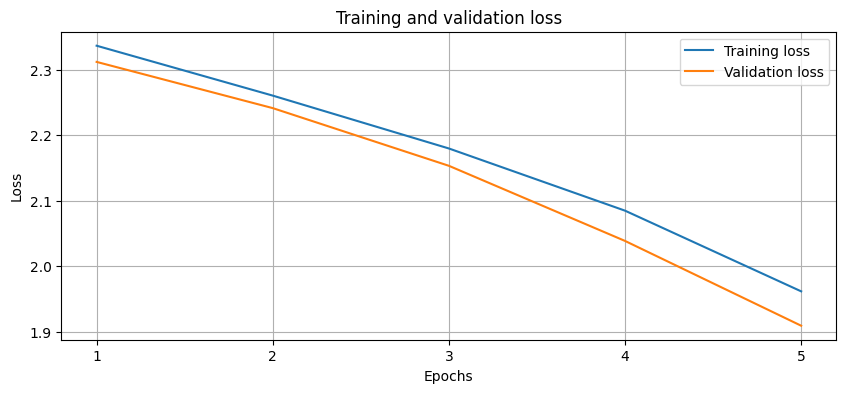

In [11]:
# Plot the training and validation loss
history = model.history.history
epochs = range(1, len(history["loss"]) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, history["loss"], label="Training loss")
plt.plot(epochs, history["val_loss"], label="Validation loss")
plt.xticks(epochs)
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Print validation metrics
val_loss, val_acc = model.evaluate(ds_test)
print(f"Validation loss: {val_loss:.2f}")
print(f"Validation accuracy: {val_acc * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9121 - sparse_categorical_accuracy: 0.3466 
Validation loss: 1.91
Validation accuracy: 35.51%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


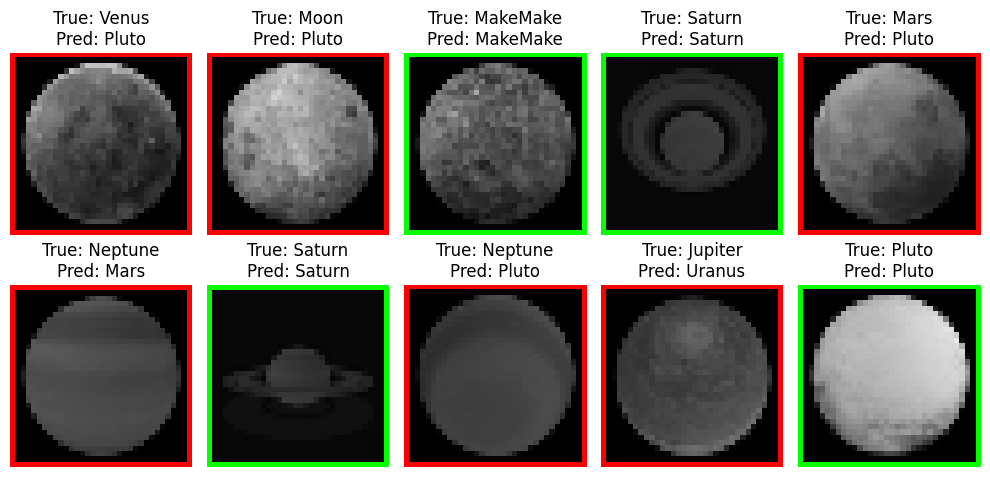

In [13]:
# Take 10 random images from the test set and show the model's predictions
plt.figure(figsize=(10, 5), tight_layout=True)
for images, label_idxs in ds_test.take(1):
    preds = model.predict(images)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img = (images[i].numpy() * 255).astype("uint8")
        # Convert image to rgb if grayscale
        if img.shape[-1] == 1:
            img = np.squeeze(img, axis=-1)
            img = np.stack((img,) * 3, axis=-1)
        true_label = labels[label_idxs[i].numpy()]
        pred_label = labels[np.argmax(preds[i])]
        # Add red border if the prediction is wrong else add green border
        img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)))
        if true_label != pred_label:
            img[0, :, 0] = 255  # Top border
            img[-1, :, 0] = 255  # Bottom border
            img[:, 0, 0] = 255  # Left border
            img[:, -1, 0] = 255  # Right border
        else:
            img[0, :, 1] = 255
            img[-1, :, 1] = 255
            img[:, 0, 1] = 255
            img[:, -1, 1] = 255

        plt.imshow(img)
        plt.title(f"True: {true_label}\n" f"Pred: {pred_label}")
        plt.axis("off")
plt.show()

 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


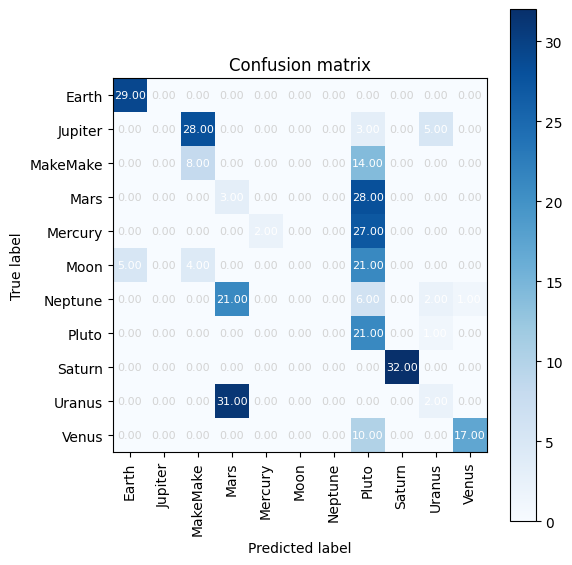

In [15]:
# Show confusion matrix of confidence per class for the test set
plt.figure(figsize=(6, 6), tight_layout=True)
preds = model.predict(ds_test)

conf_matrix = tf.math.confusion_matrix(
    labels=tf.concat([y for _, y in ds_test], axis=0),
    predictions=tf.argmax(preds, axis=1),
    num_classes=len(labels),
)

# Plot the confusion matrix
plt.imshow(conf_matrix, cmap="Blues")

# Plot cell values
for i in range(len(labels)):
    for j in range(len(labels)):
        value = conf_matrix[i, j].numpy()
        if value == 0:
            color = "lightgray"
        elif value > 0.5:
            color = "white"
        else:
            color = "black"
        plt.text(
            j,
            i,
            f"{value:.2f}",
            ha="center",
            va="center",
            color=color,
            fontsize=8,
        )

plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show()